<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session7/blob/main/Sentiment_analysis_stanford_treebank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Sentiment analysis using LSTM on  [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/)**

### Import libraries

In [ ]:
# mount g-drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
import pandas as pd
import sys
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import time
import torch, torchtext
from torchtext import legacy
from torchtext.legacy import data
# Manual Seed
RANDOM_SEED = 55
torch.manual_seed(RANDOM_SEED)
path='/content/drive/MyDrive/TSAI_data/SST_5/SST_data_extraction-master/SST_data_extraction-master'

## Load dataset
The [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST-5, or SST-fine-grained) dataset consists of 11,855 sentences extracted from movie reviews with fine-grained sentiment labels [1-5], as well as 215,154 phrases that compose each sentence in the dataset.
In the fine-grained version of SST, there are 5 different classes (very negative, negative, neutral, positive, very positive).

The full-sentence text and their class labels are extracted from 'dataSentences.txt','dictionary.txt' and 'sentiment_labels.txt using following functions.

In [ ]:
!ls

drive  sample_data  tokenizer.pkl


Load  `datasetSentences.txt` which contains 11,855 sentences extracted from movie reviews.Clean dataset to remove special characters to match it with phrases dataset in later stage.

In [ ]:
import csv,unicodedata,sys

sentences={}# save cleaned sentences in this dictionary where sentence indices are key , sentences are values
with open(os.path.join(path, 'datasetSentences.txt'),"r") as f:
	rd=csv.reader(f,delimiter='\t')
	count=0
	for line in rd:
		if count==0:
			count=1
			continue
		line[1]=line[1].replace('-LRB-','(')
		line[1]=line[1].replace('-RRB-',')')
		line[1]=line[1].replace('Â', '')
		line[1]=line[1].replace('Ã©', 'e')
		line[1]=line[1].replace('Ã¨', 'e')
		line[1]=line[1].replace('Ã¯', 'i')
		line[1]=line[1].replace('Ã³', 'o')
		line[1]=line[1].replace('Ã´', 'o')
		line[1]=line[1].replace('Ã¶', 'o')
		line[1]=line[1].replace('Ã±', 'n')
		line[1]=line[1].replace('Ã¡', 'a')
		line[1]=line[1].replace('Ã¢', 'a')
		line[1]=line[1].replace('Ã£', 'a')
		line[1]=line[1].replace('\xc3\x83\xc2\xa0', 'a')
		line[1]=line[1].replace('Ã¼', 'u')
		line[1]=line[1].replace('Ã»', 'u')
		line[1]=line[1].replace('Ã§', 'c')
		line[1]=line[1].replace('Ã¦', 'ae')
		line[1]=line[1].replace('Ã­', 'i')
		line[1]=line[1].replace('\xa0', ' ')
		line[1]=line[1].replace('\xc2', '')
		sentences[line[0]]=line[1]


Let's view `sentences` dictionary cleaned review sentences

In [ ]:
sentences

{'1': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 '2': "The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .",
 '3': 'Effective but too-tepid biopic',
 '4': 'If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .',
 '5': "Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .",
 '6': 'The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .',
 '7': 'Offers that rare combination of entertainment and education .',
 '8': 'Perhaps no picture ever made has more literally showed that the road to hell is pav

In [ ]:
 #create dataframe from sentences dictionary
 cleaned_sentence_data=pd.DataFrame(sentences.items(), columns=['sentence_ids', 'sentence'])
 cleaned_sentence_data

,sentence_ids,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."
...,...,...
11850,11851,A real snooze .
11851,11852,No surprises .
11852,11853,We 've seen the hippie-turned-yuppie plot befo...
11853,11854,Her fans walked out muttering words like `` ho...


Load `dictionary.txt` which contains 215,154 phrases that compose each sentence in the review dataset and their IDs, separated by a vertical lineand .Then clean dataset to remove special charactors.

In [ ]:
phrases={}
with open(os.path.join(path, 'dictionary.txt'),"r") as f:#  save cleaned phrases in this dictionary where phrases are key , indicess are values
	rd=csv.reader(f,delimiter='|')
	for line in rd:
		line[0]=line[0].replace('é','e')
		line[0]=line[0].replace('è','e')
		line[0]=line[0].replace('ï','i')
		line[0]=line[0].replace('í','i')
		line[0]=line[0].replace('ó','o')
		line[0]=line[0].replace('ô','o')
		line[0]=line[0].replace('ö','o')
		line[0]=line[0].replace('á','a')
		line[0]=line[0].replace('â','a')
		line[0]=line[0].replace('ã','a')
		line[0]=line[0].replace('à','a')
		line[0]=line[0].replace('ü','u')
		line[0]=line[0].replace('û','u')
		line[0]=line[0].replace('ñ','n')
		line[0]=line[0].replace('ç','c')
		line[0]=line[0].replace('æ','ae')
		line[0]=line[0].replace('\xa0', ' ')
		line[0]=line[0].replace('\xc2', '')
		phrases[line[0]]=line[1]

In [ ]:
#create dataframe from phrases dictionary
cleaned_phrases_data=pd.DataFrame(phrases.items(), columns=['phrase', 'phrase_ids'])
cleaned_phrases_data

,phrase,phrase_ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936
...,...,...
239181,zoning ordinances,220440
239182,zoning ordinances to protect your community fr...,220441
239183,zzzzzzzzz,179256
239184,É,220443


Load `sentiment_labels.txt` that contains all phrase ids and the corresponding sentiment labels, separated by a vertical line.

In [ ]:
labels={}
with open(os.path.join(path, 'sentiment_labels.txt'),"r") as f:
	rd=csv.reader(f,delimiter='|')
	count=0
	for line in rd:
		if count==0:
			count=1
			continue
		labels[line[0]]=float(line[1])# convert labels from string to float for further processing

In [ ]:
labels

{'0': 0.5,
 '1': 0.5,
 '2': 0.44444,
 '3': 0.5,
 '4': 0.42708,
 '5': 0.375,
 '6': 0.41667,
 '7': 0.54167,
 '8': 0.33333,
 '9': 0.45833,
 '10': 0.47222,
 '11': 0.59722,
 '12': 0.33333,
 '13': 0.93056,
 '14': 0.80556,
 '15': 0.81944,
 '16': 0.76389,
 '17': 0.5,
 '18': 0.5,
 '19': 0.69444,
 '20': 0.5,
 '21': 0.75,
 '22': 0.29167,
 '23': 0.31944,
 '24': 0.73611,
 '25': 0.77778,
 '26': 0.59722,
 '27': 0.58333,
 '28': 0.68056,
 '29': 0.48611,
 '30': 0.52778,
 '31': 0.23611,
 '32': 0.29167,
 '33': 0.56944,
 '34': 0.375,
 '35': 0.47222,
 '36': 0.29167,
 '37': 0.375,
 '38': 0.30556,
 '39': 0.52778,
 '40': 0.18056,
 '41': 0.61111,
 '42': 0.59722,
 '43': 0.72222,
 '44': 0.33333,
 '45': 0.52778,
 '46': 0.40278,
 '47': 0.22222,
 '48': 0.31944,
 '49': 0.29167,
 '50': 0.66667,
 '51': 0.61111,
 '52': 0.43056,
 '53': 0.77778,
 '54': 0.40278,
 '55': 0.55556,
 '56': 0.55556,
 '57': 0.76389,
 '58': 0.18056,
 '59': 0.43056,
 '60': 0.36111,
 '61': 0.47222,
 '62': 0.33333,
 '63': 0.31944,
 '64': 0.5,
 '65': 

In [ ]:
#make dataframe from labels dictionary
cleaned_phrases_label_data=pd.DataFrame(labels.items(), columns=['phrase_ids', 'sentiment_values'])
cleaned_phrases_label_data

,phrase_ids,sentiment_values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708
...,...,...
239227,239227,0.36111
239228,239228,0.38889
239229,239229,0.33333
239230,239230,0.88889


In [ ]:
# dictionary to map sentiment classes to labels
sentiment={1.0:"very negative", 2.0: "negative",3.0: "neutral",4.0: "positive" ,5.0:"very positive"}

Combine cleaned sentence dataset ,phrases dataset and labels dataset to get final dataset in the form of "sentence" and "label"

In [ ]:

def process_data(df_sentence_data,df_phrase_data,df_phrase_label,sentiment):
  
  #combine data frames containing phrase and phrase sentiment
  df_phrase_data_processed= df_phrase_data.merge(df_phrase_label, how='inner', on='phrase_ids')
  #combine phrase processed dataframe with sentence dataframe to get sentence level sentiments
  df_sentence_data_processed= df_sentence_data.merge(df_phrase_data_processed, how='left', left_on='sentence',right_on='phrase')
  # converting continous sentiment values into discrete sentiment classes
  df_sentence_data_processed['label']=pd.to_numeric(pd.cut(df_sentence_data_processed['sentiment_values'], bins=[-0.001,0.2,0.4,0.6,0.8,1.1], labels=[1,2,3,4,5]))
  #adding labels corresponds to each sentiment class
  df_sentence_data_processed['sentiment_class'] = df_sentence_data_processed['label'].map(sentiment)
  return df_sentence_data_processed

In [ ]:
processed_data=process_data(cleaned_sentence_data,cleaned_phrases_data,cleaned_phrases_label_data,sentiment)
processed_data

,sentence_ids,sentence,phrase,phrase_ids,sentiment_values,label,sentiment_class
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,0.69444,4.0,positive
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,0.83333,5.0,very positive
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,0.51389,3.0,neutral
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,0.73611,4.0,positive
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,0.86111,5.0,very positive
...,...,...,...,...,...,...,...
11850,11851,A real snooze .,A real snooze .,222071,0.11111,1.0,very negative
11851,11852,No surprises .,No surprises .,225165,0.22222,2.0,negative
11852,11853,We 've seen the hippie-turned-yuppie plot befo...,We 've seen the hippie-turned-yuppie plot befo...,226985,0.75000,4.0,positive
11853,11854,Her fans walked out muttering words like `` ho...,Her fans walked out muttering words like `` ho...,223632,0.13889,1.0,very negative


In [ ]:
#selecting only columns required for training
df=processed_data[["sentence","label"]].reset_index(drop=True)
df

,sentence,label
0,The Rock is destined to be the 21st Century 's...,4.0
1,The gorgeously elaborate continuation of `` Th...,5.0
2,Effective but too-tepid biopic,3.0
3,If you sometimes like to go to the movies to h...,4.0
4,"Emerges as something rare , an issue movie tha...",5.0
...,...,...
11850,A real snooze .,1.0
11851,No surprises .,2.0
11852,We 've seen the hippie-turned-yuppie plot befo...,4.0
11853,Her fans walked out muttering words like `` ho...,1.0


In [ ]:
#checking for nan rows
processed_data[processed_data.isna().any(axis=1)]


,sentence_ids,sentence,phrase,phrase_ids,sentiment_values,label,sentiment_class
1439,1440,"Vera 's three actors -- MollÃ , Gil and Barde...",NaN,NaN,NaN,NaN,NaN


In [ ]:
#remove one row with nan label
df=df.dropna().reset_index(drop=True)
df

,sentence,label
0,The Rock is destined to be the 21st Century 's...,4.0
1,The gorgeously elaborate continuation of `` Th...,5.0
2,Effective but too-tepid biopic,3.0
3,If you sometimes like to go to the movies to h...,4.0
4,"Emerges as something rare , an issue movie tha...",5.0
...,...,...
11849,A real snooze .,1.0
11850,No surprises .,2.0
11851,We 've seen the hippie-turned-yuppie plot befo...,4.0
11852,Her fans walked out muttering words like `` ho...,1.0


In [ ]:
#Split dataset into train and test for modeling
(df_train, df_test) = train_test_split(df, test_size=0.3, random_state=random.seed(RANDOM_SEED))

assert len(df_train) + len(df_test) == len(df)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)


We can see how many examples are in each split by checking their length.

In [ ]:
len(df_train),len(df_test)

(8297, 3557)

Let's view data distribution across different classes in final dataset

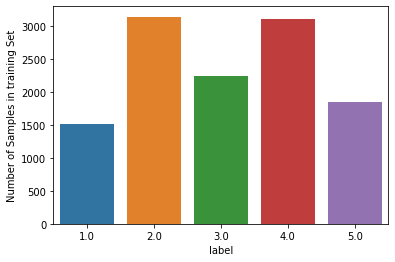

In [ ]:
from seaborn import countplot
from matplotlib.pyplot import figure, show

ax = countplot(data=df,x=df.label)
ax.set_ylabel('Number of Samples in training Set')
ax.set_xlabel('label')
show()

Let's view data distribution across different classes in train dataset

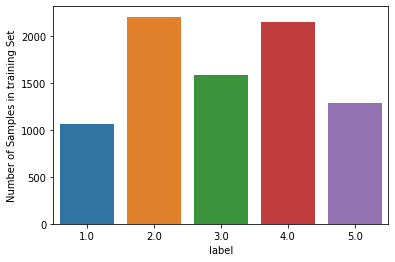

In [ ]:
from seaborn import countplot
from matplotlib.pyplot import figure, show

ax = countplot(data=df_train,x=df_train.label)
ax.set_ylabel('Number of Samples in training Set')
ax.set_xlabel('label')
show()

### Defining Fields
One of the main concepts of TorchText is the Field. These define how our data should be processed. 

Now we shall be defining LABEL as a LabelField, which is a subclass of Field . Text is a standard Field object, where we have decided to use the spaCy tokenizer.

In [ ]:
Text = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True) #Defines a datatype together with instructions for converting to Tensor.
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the sentence:

In [ ]:
fields=[('sentence',Text),('label',Label)]

In [ ]:
df_train.shape[0]

8297

In [ ]:
df_train

,sentence,label
0,That 's why Sex and Lucia is so alluring .,4.0
1,"A densely constructed , highly referential fil...",5.0
2,What might 've been an exhilarating exploratio...,3.0
3,This is SO De Palma .,3.0
4,Just a bunch of good actors flailing around in...,1.0
...,...,...
8292,Not only does the thoroughly formulaic film re...,1.0
8293,"Well-acted , well-directed and , for all its m...",5.0
8294,A cheap scam put together by some cynical cree...,1.0
8295,"At some point , all this visual trickery stops...",2.0


In [ ]:
example_train=[data.Example.fromlist([df_train.sentence[i],df_train.label[i]],fields) for i in range (df_train.shape[0])]

In [ ]:
train = torchtext.legacy.data.Dataset(example_train, fields)

In [ ]:
example_test=[data.Example.fromlist([df_test.sentence[i],df_test.label[i]],fields) for i in range (df_test.shape[0])]

In [ ]:
test=torchtext.legacy.data.Dataset(example_test,fields)

Let's look at one of the examples in the training set

In [ ]:
vars(train.examples[10])

{'label': 1.0,
 'sentence': ['A',
  'period',
  'story',
  'about',
  'a',
  'Catholic',
  'boy',
  'who',
  'tries',
  'to',
  'help',
  'a',
  'Jewish',
  'friend',
  'get',
  'into',
  'heaven',
  'by',
  'sending',
  'the',
  'audience',
  'straight',
  'to',
  'hell',
  '.']}

In [ ]:
vars(test.examples[10])

{'label': 3.0,
 'sentence': ['It', "'s", 'a', 'fanboy', '`', 'what', 'if', '?', "'"]}

### Building Vocabulary



Next, we have to build a *vocabulary*. This is effectively a look up table where every unique word in your data set has a corresponding *index* (an integer).

We do this as our  model cannot operate on strings, only numbers. Each *index* is used to construct a *one-hot* vector for each word.

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"glove.6B.100d" vectors"`. `6B` indicates these vectors were trained on 6 billion tokens and `100d` indicates these vectors are 100-dimensional.
By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting unk_init to torch.Tensor.normal_. This will now initialize those words via a Gaussian distribution.



In [ ]:
MAX_VOCAB_SIZE=15_000
Text.build_vocab(train, vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [ ]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16997
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7806), (',', 6931), ('the', 5880), ('and', 4334), ('a', 4318), ('of', 4278), ('to', 2969), ('-', 2719), ('is', 2500), ("'s", 2477)]
Labels :  defaultdict(None, {2.0: 0, 4.0: 1, 3.0: 2, 5.0: 3, 1.0: 4})


### Creating data iterators

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.


But at first declare the device we are using.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, test_iterator = data.BucketIterator.splits((train, test), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [ ]:
next(iter(train_iterator))


[torchtext.legacy.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x8 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [ ]:
next(iter(test_iterator))


[torchtext.legacy.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x3 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

Save the vocabulary for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

### Defining Our Model

We use the `Embedding` and `LSTM` modules in` PyTorch` to build a simple model for classifying reviews.

In this model we create three layers.

1. First, the words in our texts are pushed into an Embedding layer, which we have established as a 100-dimensional vector embedding.
2. That’s then fed into a 2 stacked-LSTMs with 256 hidden features 
3. Finally, the output of the LSTM (the final hidden state after processing the incoming text) is pushed through a standard fully connected layer with five outputs to correspond to our five possible classes (strongly negative,weakly negative, neutral ,strongly positive or weakly positive ).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout,pad_idx):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx = pad_idx)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)

        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        hidden=self.dropout(hidden)
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

We'll create an instance of our classifier class, with the  parameters and arguments for the number of layers,  and dropout probability.

To ensure the pre-trained vectors can be loaded into the model, the `embedding_dim` must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's pad_token attribute, which is <pad> by default.

In [ ]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = 5
num_layers = 2
dropout = 0.5
PAD_IDX = Text.vocab.stoi[Text.pad_token]
# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout, PAD_IDX)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16997, 100, padding_idx=1)
  (encoder): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,593,913 trainable parameters


In [ ]:
#view size of model parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


torch.Size([16997, 100])
torch.Size([1024, 100])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024, 256])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([5, 256])
torch.Size([5])


We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]

In [ ]:
pretrained_embeddings = Text.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([16997, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.8616,  0.9035,  1.3395,  ...,  1.8470,  0.7820,  0.4633],
        [-1.2975,  1.9905,  1.0233,  ...,  0.0393,  0.0713, -0.1407],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.1509,  0.2089,  0.7544,  ..., -0.2359,  0.4850,  0.0263],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-0.4641, -1.6736,  0.2459,  ..., -1.3258, -0.2639,  1.4271]])

As our <unk> and <pad> token aren't in the pre-trained vocabulary they have been initialized using unk_init (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

We do this by manually setting their row in the embedding weights matrix to zeros.

In [ ]:

UNK_IDX = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.1509,  0.2089,  0.7544,  ..., -0.2359,  0.4850,  0.0263],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-0.4641, -1.6736,  0.2459,  ..., -1.3258, -0.2639,  1.4271]])


### Model Training and Evaluation

First define the optimizer and loss functions
We use `CrossEntropyLoss` as loss function .`CrossEntropyLoss` performs a softmax function over our model outputs and the loss is given by the cross entropy between that and the label.
We use `Adam` as optimizer.`Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates

In [ ]:
import torch.optim as optim
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define evaluation metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    _, predictions = torch.max(preds, 1)
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

#  place the model and criterion on the GPU 
model = model.to(device)
criterion = criterion.to(device)

**Training Loop**

We define a function for training our model.

As we have set `include_lengths = True`, our batch.sentence is now a tuple with the first element being the numericalized tensor and the second element being the actual lengths of each sequence. We separate these into their own variables, text and text_lengths, before passing them to the model.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text, text_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = categorical_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

Then we define a function for testing our model

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [ ]:


N_EPOCHS = 30
best_test_loss = float('inf')
train_los=[]
train_accuracy=[]
test_los=[]
test_accuracy=[]

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_los.append(train_loss)
    train_accuracy.append(train_acc)

    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    test_los.append(test_loss)
    test_accuracy.append(test_acc)
    
    # save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

	Train Loss: 1.517 | Train Acc: 37.03%
	 Val. Loss: 1.521 |  Val. Acc: 36.98% 

	Train Loss: 1.499 | Train Acc: 39.03%
	 Val. Loss: 1.514 |  Val. Acc: 37.23% 

	Train Loss: 1.476 | Train Acc: 41.56%
	 Val. Loss: 1.501 |  Val. Acc: 38.60% 

	Train Loss: 1.465 | Train Acc: 42.99%
	 Val. Loss: 1.503 |  Val. Acc: 38.72% 

	Train Loss: 1.456 | Train Acc: 44.17%
	 Val. Loss: 1.492 |  Val. Acc: 39.94% 

	Train Loss: 1.421 | Train Acc: 47.80%
	 Val. Loss: 1.495 |  Val. Acc: 39.38% 

	Train Loss: 1.400 | Train Acc: 50.16%
	 Val. Loss: 1.492 |  Val. Acc: 39.49% 

	Train Loss: 1.395 | Train Acc: 50.77%
	 Val. Loss: 1.496 |  Val. Acc: 39.15% 

	Train Loss: 1.365 | Train Acc: 54.05%
	 Val. Loss: 1.493 |  Val. Acc: 39.24% 

	Train Loss: 1.355 | Train Acc: 55.11%
	 Val. Loss: 1.490 |  Val. Acc: 39.99% 

	Train Loss: 1.340 | Train Acc: 56.64%
	 Val. Loss: 1.492 |  Val. Acc: 39.29% 

	Train Loss: 1.319 | Train Acc: 59.04%
	 Val. Loss: 1.500 |  Val. Acc: 38.64% 

	Train Loss: 1.305 | Train Acc: 60.28%
	

Let's view train and test loss

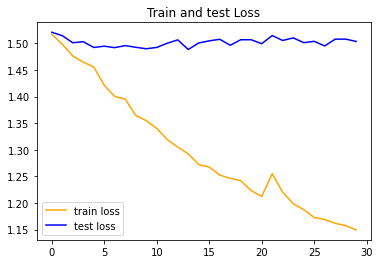

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_los,label='train loss',color="orange")
plt.plot(test_los,label='test loss ',color="blue")
plt.title("Train and test Loss")
plt.legend()
plt.show()

Now , let's view train and test accuracy

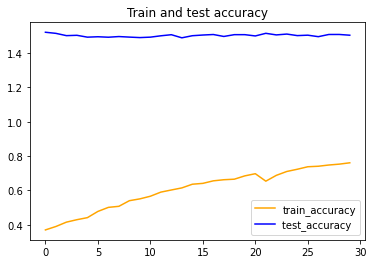

In [ ]:
plt.plot(train_accuracy,label='train_accuracy',color="orange")
plt.plot(test_los,label='test_accuracy ',color="blue")
plt.title("Train and test accuracy")
plt.legend()
plt.show()

### User Input
We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.



In [ ]:
# load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();#sets the model to evaluation mode
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_review(sentence):
    categories = {4: "very negative", 0:"negative", 2:"neutral",1:"positive",3:"very positive"}
    # Labels :  defaultdict(None, {2.0: 0, 4.0: 1, 3.0: 2, 5.0: 3, 1.0: 4})
    #  ground truth : {1.0: "very negative", 2.0:"negative", 3.0:"neutral", 4.0:'positive', 5.0: 'very positive'}
    
    # tokenize the sentences 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

### Predictions on test set

In [ ]:

df_eval = pd.DataFrame(
    [(df_test['sentence'][idx], sentiment[df_test['label'][idx]], classify_review(df_test['sentence'][idx])) for idx in df_test.index]
    , columns=['sentence','label', 'predicted']
)

In [ ]:
df_eval

,sentence,label,predicted
0,"Occasionally melodramatic , it 's also extreme...",positive,positive
1,"There are as many misses as hits , but ultimat...",positive,positive
2,But tongue-in-cheek preposterousness has alway...,positive,positive
3,"Wince-inducing dialogue , thrift-shop costumes...",very negative,neutral
4,"Apart from its own considerable achievement , ...",neutral,positive
...,...,...,...
3552,Mindless and boring martial arts and gunplay w...,negative,neutral
3553,"A bland , obnoxious 88-minute infomercial for ...",negative,neutral
3554,Escapism in its purest form .,positive,positive
3555,The farcical elements seemed too pat and famil...,neutral,neutral


In [ ]:
df_eval['predicted'].value_counts()

negative         1310
positive         1121
neutral           764
very positive     362
Name: predicted, dtype: int64

#### Correctly predicted samples

In [ ]:
#correct predictions 
df_correct = df_eval[df_eval['label'] == df_eval['predicted']]
df_correct

,sentence,label,predicted
0,"Occasionally melodramatic , it 's also extreme...",positive,positive
1,"There are as many misses as hits , but ultimat...",positive,positive
2,But tongue-in-cheek preposterousness has alway...,positive,positive
7,"Director Paul Cox 's unorthodox , abstract app...",positive,positive
8,Take away all the cliches and the carbon copy ...,neutral,neutral
...,...,...,...
3548,At its best early on as it plays the culture c...,positive,positive
3549,What could have been a neat little story about...,negative,negative
3551,... would be a total loss if not for two suppo...,neutral,neutral
3554,Escapism in its purest form .,positive,positive


In [ ]:
correct_test_samples=df_correct.sample(n=5).reset_index(drop=True)
for i in range(correct_test_samples.shape[0]):
  print(f'Review : {correct_test_samples.sentence[i]}')
  print(f'Actual Sentiment : {correct_test_samples.label[i]} | Predicted Sentiment : {correct_test_samples.predicted[i]} \n')

Review : The crassness of this reactionary thriller is matched only by the ridiculousness of its premise .
Actual Sentiment : negative | Predicted Sentiment : negative 

Review : The tug-of-war at the core of Beijing Bicycle becomes weighed down with agonizing contrivances , overheated pathos and long , wistful gazes .
Actual Sentiment : negative | Predicted Sentiment : negative 

Review : Plays like one long , meandering sketch inspired by the works of John Waters and Todd Solondz , rather than a fully developed story .
Actual Sentiment : negative | Predicted Sentiment : negative 

Review : Goofy , nutty , consistently funny .
Actual Sentiment : very positive | Predicted Sentiment : very positive 

Review : It has fun being grown up .
Actual Sentiment : positive | Predicted Sentiment : positive 



#### Incorrectly predicted samples

In [ ]:

# incorrect predictions
df_incorrect = df_eval[df_eval['label'] != df_eval['predicted']]
df_incorrect

,sentence,label,predicted
3,"Wince-inducing dialogue , thrift-shop costumes...",very negative,neutral
4,"Apart from its own considerable achievement , ...",neutral,positive
5,"Yes , soar .",positive,neutral
6,"An authentically vague , but ultimately purpos...",negative,neutral
9,There 's no question that Epps scores once or ...,neutral,negative
...,...,...,...
3547,"A fine , rousing , G-rated family film , aimed...",very positive,positive
3550,When twentysomething hotsies make movies about...,positive,neutral
3552,Mindless and boring martial arts and gunplay w...,negative,neutral
3553,"A bland , obnoxious 88-minute infomercial for ...",negative,neutral


In [ ]:
incorrect_test_samples=df_incorrect.sample(n=5).reset_index(drop=True)
for i in range(incorrect_test_samples.shape[0]):
  print(f'Review : {incorrect_test_samples.sentence[i]}')
  print(f'Actual Sentiment : {incorrect_test_samples.label[i]} | Predicted Sentiment : {incorrect_test_samples.predicted[i]} \n')

Review : A modestly made but profoundly moving documentary .
Actual Sentiment : very positive | Predicted Sentiment : positive 

Review : A `` Home Alone '' film that is staged like `` Rosemary 's Baby , '' but is not as well-conceived as either of those films .
Actual Sentiment : negative | Predicted Sentiment : neutral 

Review : There are a few chuckles , but not a single gag sequence that really scores , and the stars seem to be in two different movies .
Actual Sentiment : neutral | Predicted Sentiment : negative 

Review : Has something to say ... but it is a statement and issue worthy of a much more thoughtfulness and insight than a melodramatic and wholly predictable thriller .
Actual Sentiment : neutral | Predicted Sentiment : positive 

Review : The ga-zillionth airhead movie about a wife in distress who resorts to desperate measures .
Actual Sentiment : neutral | Predicted Sentiment : negative 



### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
from matplotlib import pyplot as plt
classification_report= pd.DataFrame(classification_report(df_eval['label'].values, df_eval['predicted'].values, output_dict=True)).transpose()
classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
negative,0.418321,0.587983,0.488849,932.000000
neutral,0.248691,0.288316,0.267041,659.000000
positive,0.430865,0.503650,0.464423,959.000000
very negative,0.000000,0.000000,0.000000,441.000000
very positive,0.549724,0.351590,0.428879,566.000000
accuracy,0.399213,0.399213,0.399213,0.399213
macro avg,0.329520,0.346308,0.329839,3557.000000
weighted avg,0.359321,0.399213,0.371019,3557.000000



### Confusion matrix

[Text(0, 0.5, 'very positive'),
 Text(0, 1.5, 'very negative'),
 Text(0, 2.5, 'positive'),
 Text(0, 3.5, 'neutral'),
 Text(0, 4.5, 'negative')]

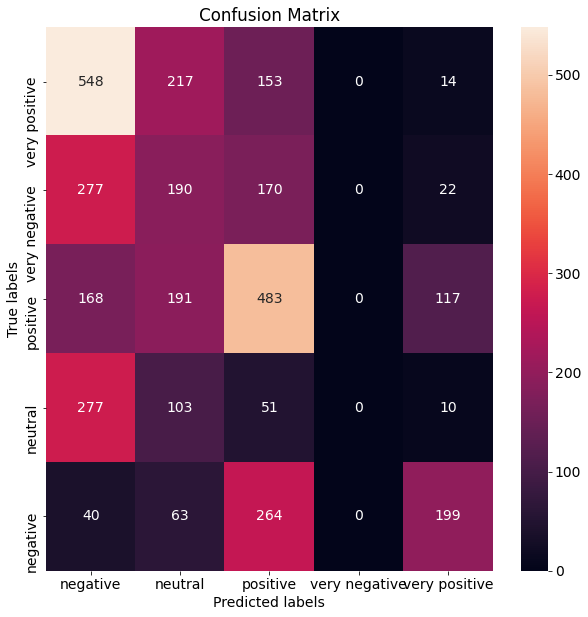

In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_eval['label'].values, df_eval['predicted'].values)

import seaborn as sns
import matplotlib.pyplot as plt     

classes= ["negative","neutral","positive","very negative","very positive"]
font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1])